### FINAL PROJECT

PREDICTING UBER & LYFT PRICES

Project Purposes:

Predicting the potential price of uber/lyft based on the characteristic of weather and time.

Gaining information about what factors affect price of uber/lyft in Boston.   

Car Dataset 

distance: distance between source and destination

cab_type : Uber or Lyft

time_stamp : epoch time when data was queried

destination: destination of the ride

source: the starting point of the ride

price: price estimate for the ride in USD

surge_multiplier: the multiplier by which price was increased, default 1

id: unique identifier

product_id: uber/lyft identifier for cab-type

name: Visible type of the cab eg: Uber Pool, UberXL
    
    
Weather Dataset 

temp: Temperature in F, 
pressure: pressure in mb, 
rain: rain in inches for the last hr
humidity: humidity in %   

location: Location name

clouds: Clouds

time_stamp: epoch time when row data was collected


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

### 1.Load Data

In [3]:
cab = pd.read_csv('cab_rides.csv') 
weather = pd.read_csv('weather.csv')

In [4]:
cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
distance            693071 non-null float64
cab_type            693071 non-null object
time_stamp          693071 non-null int64
destination         693071 non-null object
source              693071 non-null object
price               637976 non-null float64
surge_multiplier    693071 non-null float64
id                  693071 non-null object
product_id          693071 non-null object
name                693071 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
temp          6276 non-null float64
location      6276 non-null object
clouds        6276 non-null float64
pressure      6276 non-null float64
rain          894 non-null float64
time_stamp    6276 non-null int64
humidity      6276 non-null float64
wind          6276 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [31]:
#missing value check
missing_in_cab = cab.isnull().sum().sum()
percentage= round(((missing_in_cab/cab.shape[0]) * 100),2)
print(f'Cab ride dataset have {missing_in_cab} missing values, as much as {percentage} % of whole data.')

missing_in_weather= weather.isnull().sum().sum()
percent= round(((missing_in_weather/weather.shape[0]) * 100),2)
print(f'weather dataset have {missing_in_weather} missing values, as much as {percent} % of whole data.')


Cab ride dataset have 55095 missing values, as much as 7.95 % of whole data.
weather dataset have 5382 missing values, as much as 85.76 % of whole data.


#### 2. Data Cleaning

Investigate each column in the data, perform cleaning steps as required.
- Merge two data frame 
- Convert column containing epoch time to actual datetime
- Handle missing value
- Extract new variables for EDA purposes

In [7]:
#convert both dataframe time_stamp to datetime 
cab['datetime'] = pd.to_datetime(cab['time_stamp'], unit='ms')
weather['datetime'] = pd.to_datetime(weather['time_stamp'], unit='s')
cab.drop(['time_stamp'],axis=1, inplace=True) 
weather.drop(['time_stamp'],axis=1, inplace=True) 

# merge cab and weather through the same dateime and source
weather.rename(columns={"location": "source"}, inplace=True)
weather.sort_values('datetime',inplace=True)
cab.sort_values('datetime',inplace=True)
df= pd.merge_asof(cab,weather,on='datetime',by='source',direction='nearest')



#drop unecessary features 
df.drop(['id', 'product_id'],axis=1, inplace=True)


In [9]:
#Extract day,date,hour from datetime
df['hour'] = df['datetime'].dt.hour
df['date'] = df['datetime'].dt.day
df['weekday'] =  df['datetime'].dt.weekday
df['day'] = df['weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                               3: 'Thursday', 4: 'Friday', 5: 'Saturday', 
                               6: 'Sunday'})

#drop missing value in price columns since,
#we cant fill the price by mean/median or our calculation   

df.dropna(subset=['price'],axis =0, inplace=True)

#fill the missing value in rain columns, I've decided to impute it with 0 value,
#indicating that there is no rain on that day   

df.fillna(0, inplace=True)


In [11]:
#summary
desc = []
for i in df.columns:
    desc.append([i,  df[i].dtypes,
                     df[i].isna().sum(),
                     round((df[i].isna().sum())/len(df)*100,2),
                     df[i].nunique(),
                     df[i].drop_duplicates().sample(2).values])
pd.DataFrame(desc, columns = ['dataFeatures', 'dataType',
                              ' null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,distance,float64,0,0.0,549,"[1.53, 0.49]"
1,cab_type,object,0,0.0,2,"[Uber, Lyft]"
2,destination,object,0,0.0,12,"[Theatre District, Haymarket Square]"
3,source,object,0,0.0,12,"[Haymarket Square, West End]"
4,price,float64,0,0.0,147,"[56.5, 80.0]"
5,surge_multiplier,float64,0,0.0,7,"[2.0, 1.0]"
6,name,object,0,0.0,12,"[Black, UberPool]"
7,datetime,datetime64[ns],0,0.0,113945,"[2018-11-30T07:28:00.429000000, 2018-12-02T06:..."
8,temp,float64,0,0.0,2015,"[41.41, 40.32]"
9,clouds,float64,0,0.0,100,"[0.28, 0.51]"


### 2. Exploratory Data Analysis

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,637976.0,2.189261,1.135413,0.020000,1.270000,2.160000,2.930000,7.8600
price,637976.0,16.545125,9.324359,2.500000,9.000000,13.500000,22.500000,97.5000
surge_multiplier,637976.0,1.015068,0.095422,1.000000,1.000000,1.000000,1.000000,3.0000
temp,637976.0,39.205433,6.605349,19.620000,36.160000,40.090000,43.700000,55.4100
clouds,637976.0,0.669611,0.314107,0.000000,0.430000,0.760000,0.970000,1.0000
pressure,637976.0,1010.211294,13.367658,988.250000,999.950000,1009.350000,1021.870000,1035.1200
rain,637976.0,0.006756,0.039489,0.000000,0.000000,0.000000,0.000000,0.7807
humidity,637976.0,0.747566,0.128998,0.450000,0.650000,0.730000,0.870000,0.9900
wind,637976.0,6.954336,3.658039,0.290000,3.650000,6.770000,9.920000,18.1800
hour,637976.0,11.618528,6.948776,0.000000,6.000000,12.000000,18.000000,23.0000


## Price

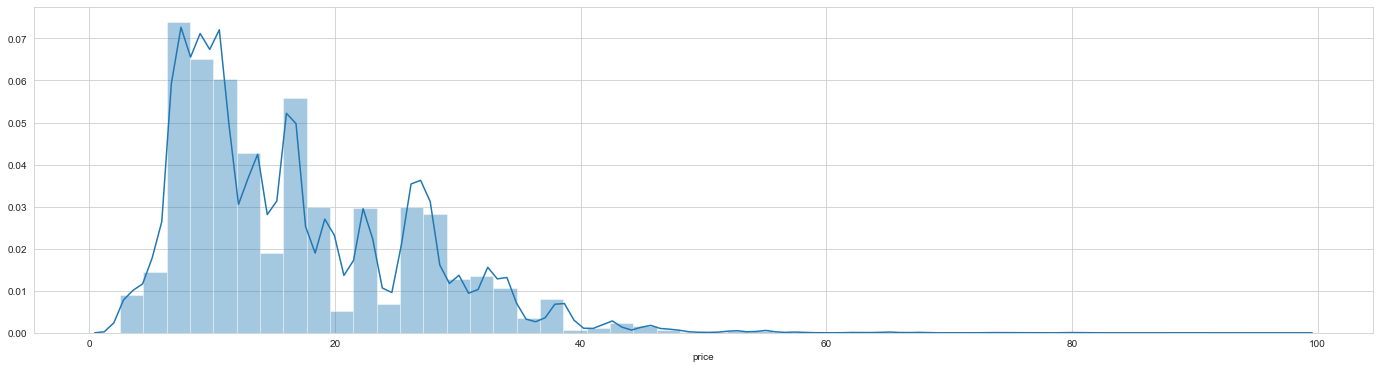

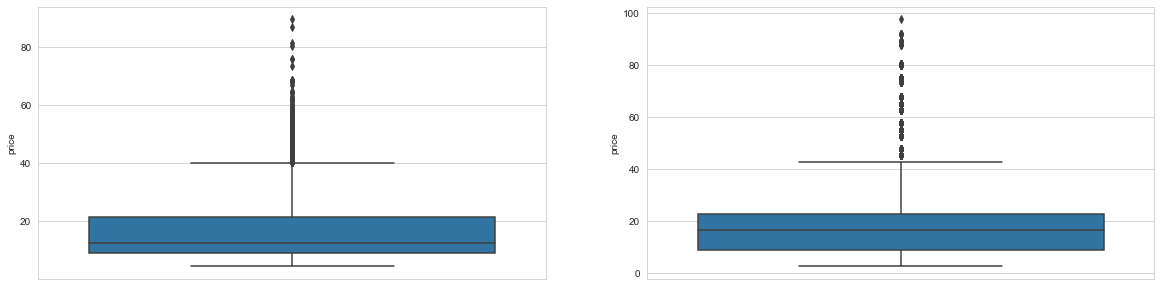

In [23]:
#Distribution plot and boxplot for target variabel


uber = df[df['cab_type']=='Uber']
lyft = df[df['cab_type']=='Lyft']

plt.figure(figsize=(24,6))
sns.set_style("whitegrid")
sns.distplot(df['price'])


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.set_style("darkgrid")
sns.boxplot(y="price", data =uber, ax=ax1 )
sns.boxplot(y="price", data =lyft, ax=ax2 )
plt.show()



The price distribution is right skewed, from the boxplot we could see the presence of outliers in the data.


In [45]:
#outlier location
outliers= df[df['price']>40].groupby(by=['name']).mean().filter(items =
                           ['price','hour', 'distance', 'surge_multiplier'])
print("Total " + str(len(df[df['price'] > 40])) + " of outlier records")
outliers.head(10)

Total 9248 of outlier records


,price,hour,distance,surge_multiplier
name,,,,
Black,43.793939,11.660606,6.593758,1.000000
Black SUV,44.242353,11.446103,5.017014,1.000000
Lux,46.636111,10.861111,4.027667,1.858333
Lux Black,49.489032,11.541935,3.543987,1.711613
Lux Black XL,48.473428,11.674553,3.778405,1.267936
Lyft XL,46.278481,11.012658,3.993924,2.234177
UberPool,42.500000,17.000000,4.410000,1.000000
UberX,42.750000,8.000000,3.915000,1.000000
UberXL,45.404040,11.616162,4.428283,1.000000


### Surge multiplier


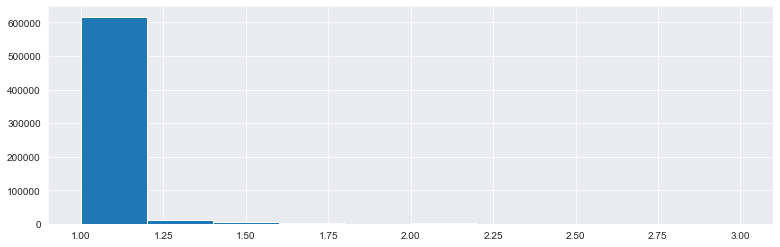

In [37]:
plt.figure(figsize=(13,4))
sns.set_style("darkgrid")
plt.hist(df['surge_multiplier'])
plt.show()

A distribution of surge multiplier variable is skewed to the right, 

### Distance Distribution

(0, 0.6)

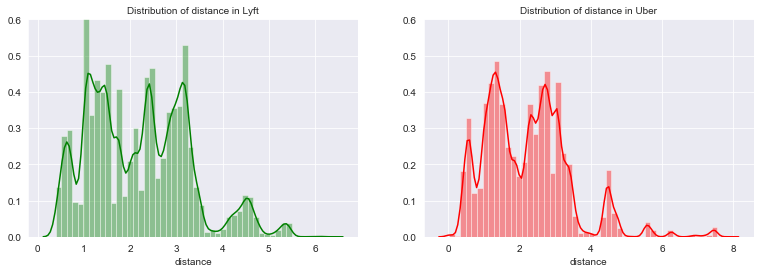

In [33]:
ig, (ax1, ax2,) = plt.subplots(ncols=2, figsize=(13, 4))
sns.distplot(lyft['distance'], ax=ax1, kde=True, color="g")
ax1.set_title('Distribution of distance in Lyft', fontsize=10)
ax1.set_ylim(0, 0.6)
a = sns.distplot(uber['distance'], ax=ax2, color="r")
ax2.set_title('Distribution of distance in Uber', fontsize=10)
ax2.set_ylim(0, 0.6)


### Temperature, Wind, Pressure Humidity and Rain Distribution 

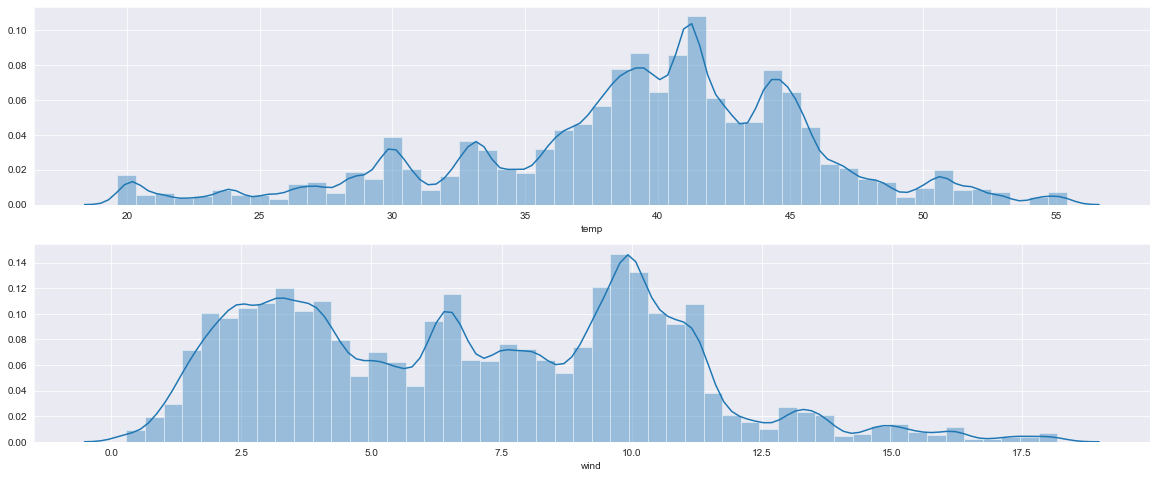

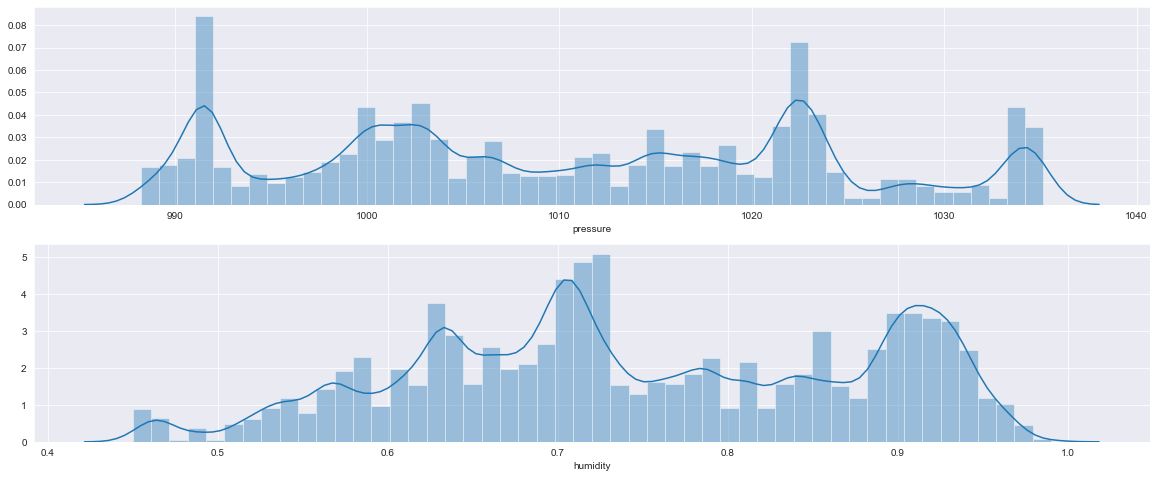

In [12]:
fig,axes=plt.subplots(2,1,figsize=(20,8))
sns.distplot(df['temp'],ax=axes[0])
sns.distplot(df['wind'],ax=axes[1])

fig,axes=plt.subplots(2,1,figsize=(20,8))
sns.distplot(df['pressure'],ax=axes[0], axlabel='pressure')
sns.distplot(df['humidity'],ax=axes[1])



Text(0, 0.5, 'Rain Index')

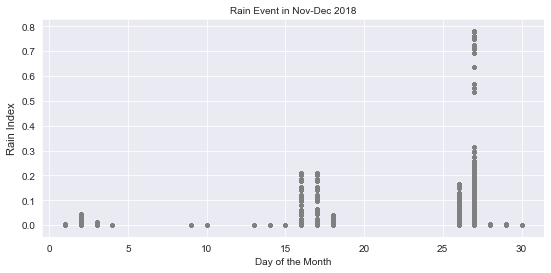

In [13]:
plt.figure(figsize=(9,4))
plt.scatter(df.date, df.rain, s=10, c="grey")
plt.title("Rain Event in Nov-Dec 2018", fontsize=10)
plt.xlabel("Day of the Month", fontsize=10)
plt.ylabel("Rain Index", fontsize=11)

#### Total Trip Based on Car Type, Top Pick Up Area and Top Destination  

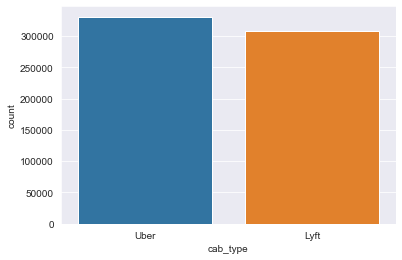

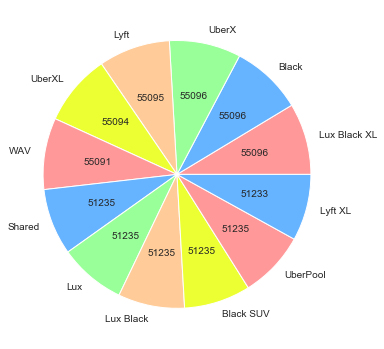

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(df['cab_type'],order=df['cab_type'].value_counts().head(10).index)

plt.figure(figsize=(6,8))
cust = df['name'].value_counts()
val= [55096, 55096, 55096, 55095, 55094, 55091, 51235, 51235, 51235,
       51235, 51235, 51233]
h= [i for i in df.name.unique()]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ECFF33']
plt.pie(val,labels=h,colors=colors,autopct=lambda p: '{:.0f}'.format((p/100)*cust.sum()))
plt.show()
plt.rcParams['font.size'] =10


Text(0.5, 1.0, ' Top 10 Destination')

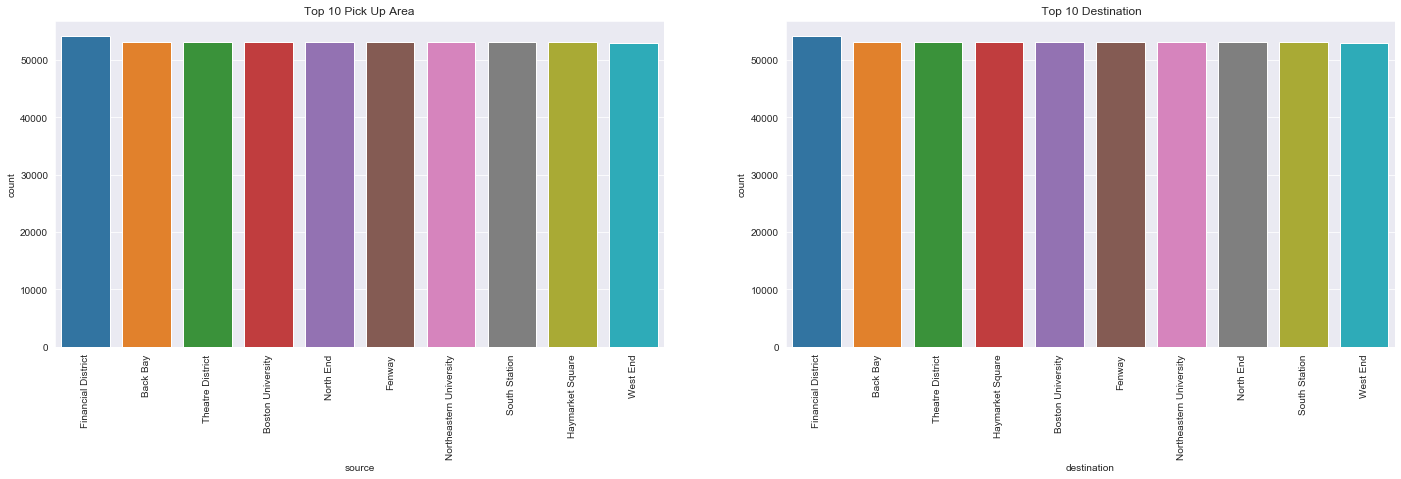

In [44]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(24,6))

sns.countplot(df['source'],ax=ax1,order=df['source'].value_counts().head(10).index)
ax1.tick_params('x',labelrotation=90)
ax1.set_title('Top 10 Pick Up Area')
sns.countplot(df['destination'],ax=ax2,order=df['destination'].value_counts().head(10).index)
ax2.tick_params('x',labelrotation=90)
ax2.set_title(' Top 10 Destination')


#### Distance, Hour, Day, Car Name, Cab Type on Price     

(0, 8)

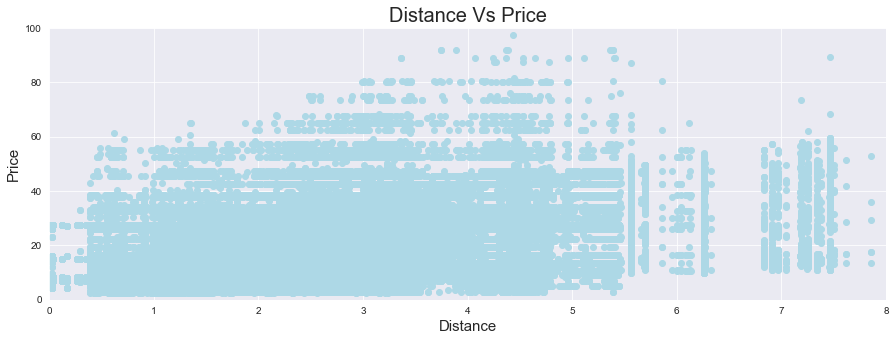

In [16]:
#distance and price plotting 

plt.figure(figsize=(15,5))
plt.scatter(df.distance, df.price, c="lightblue")
plt.title("Distance Vs Price", fontsize=20)
plt.xlabel("Distance", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.ylim(0,100)
plt.xlim(0,8)

As shown in the scatter plot,there seems to be a strong, positive, linear relationship between the distance and fare amount of a uber/lyft ride.

(0, 23)

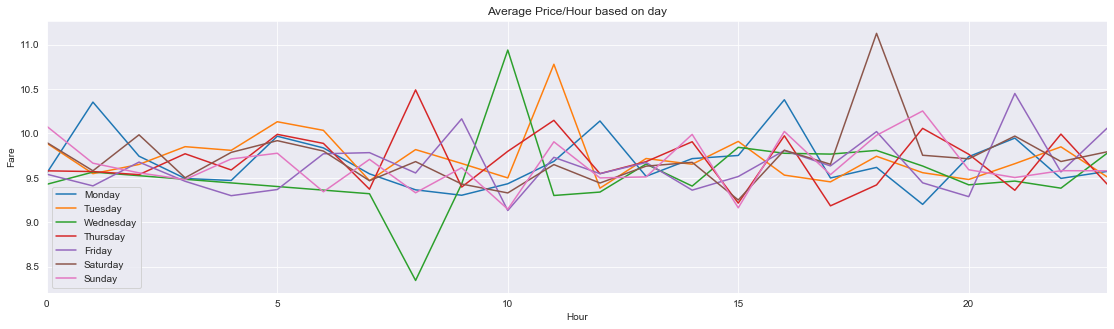

In [17]:
df['price/mile']=df['price']/df['distance']

plt.figure(figsize = (19, 5))
for item in df['day'].unique():
     plt.plot(df[df['day']==item].groupby(['hour'])['price/mile'].mean(),label=item)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.legend()
plt.title('Average Price/Hour based on day')
plt.xlim([0,23])

                                 The highest fares seem to be on Saturday, and the lowest on Wednesday. 

(0, 23)

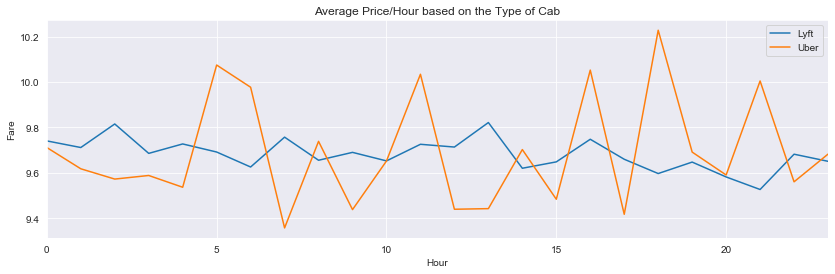

In [18]:
plt.figure(figsize = (14, 4))
for item in df['cab_type'].unique():
     plt.plot(df[df['cab_type']==item].groupby(['hour'])['price/mile'].mean(),label=item)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.legend()
plt.title('Average Price/Hour based on the Type of Cab')
plt.xlim([0,23])

(0, 12)

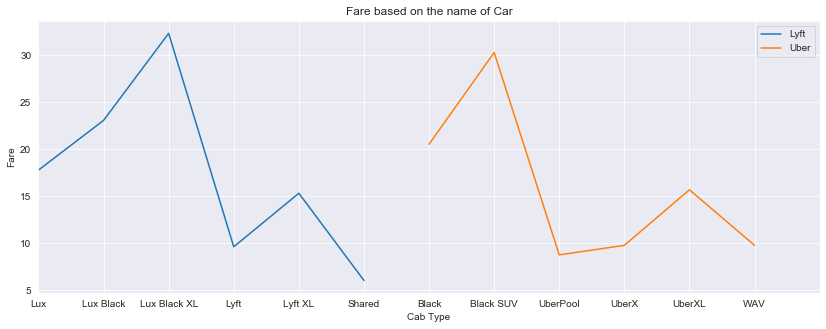

In [19]:
plt.figure(figsize = (14, 5))
for item in df['cab_type'].unique():
     plt.plot(df[df['cab_type']==item].groupby(['name'])['price'].mean(), label=item)
plt.xlabel('Cab Type')
plt.ylabel('Fare')
plt.legend()
plt.title('Fare based on the name of Car')
plt.xlim([0,12])

As we can see from the plot, Lyft prices for their premium class tend to have higher price compared to Uber meanwhile Uber tends to have higher price than Lyft on their economy rides. 

I've searched through their website and this can be the comparison of each cab type:

Black in Uber same with  Lux Black in Lyft, Black SUV same with Lux Black XL,UberPool same with Shared , UberX same with Lyft and UberXL same with to Lyft XL, WAV same with Lux

(0, 6)

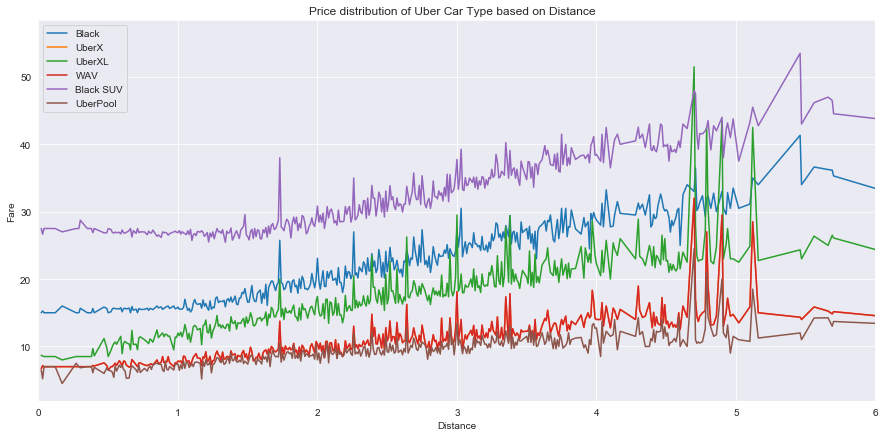

In [27]:
plt.figure(figsize = (15, 7))
for i in uber['name'].unique():
     plt.plot(uber[uber['name']==i].groupby(['distance'])['price'].mean(),label=i)
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.legend()
plt.title('Price distribution of Uber Car Type based on Distance   ')
plt.xlim([0,6])

(0, 6)

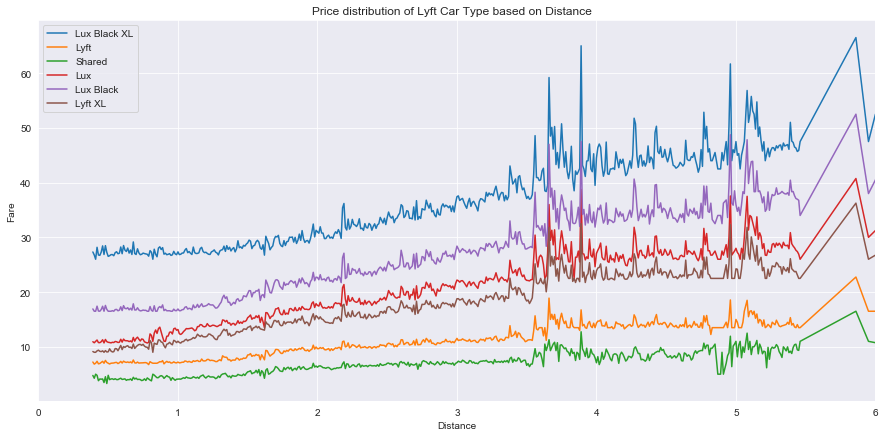

In [29]:
plt.figure(figsize = (15, 7))
for i in lyft['name'].unique():
     plt.plot(lyft[lyft['name']==i].groupby(['distance'])['price'].mean(),label=i)
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.legend()
plt.title('Price distribution of Lyft Car Type based on Distance   ')
plt.xlim([0,6])

### Price VS Weather

(20, 50)

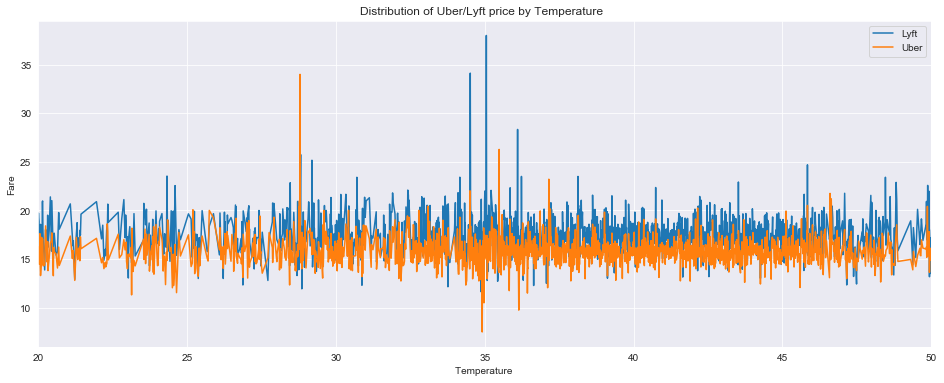

In [229]:
plt.figure(figsize = (16, 6))
for i in df['cab_type'].unique():
     plt.plot(df[df['cab_type']==i].groupby(by=['temp'])['price'].mean(),label=i)
plt.xlabel('Temperature ')
plt.ylabel('Fare')
plt.legend()
plt.title('Distribution of Uber/Lyft price by Temperature  ')
plt.xlim([20,50])

(0, 2)

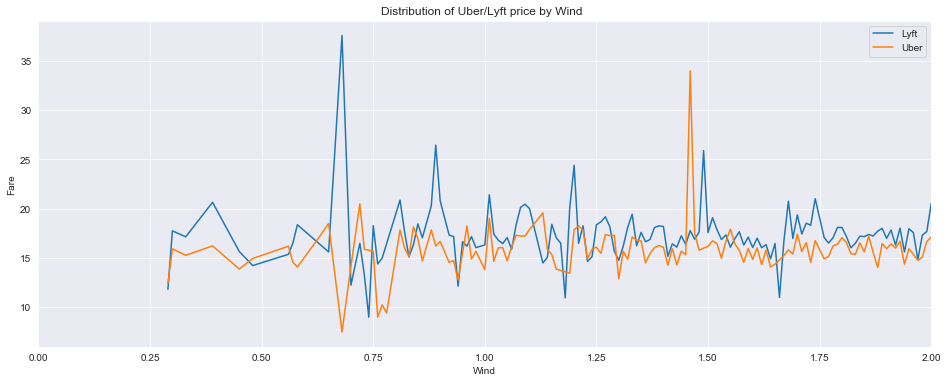

In [244]:
plt.figure(figsize = (16, 6))
for i in df['cab_type'].unique():
     plt.plot(df[df['cab_type']==i].groupby(by=['wind'])['price'].mean(),label=i)
plt.xlabel('Wind')
plt.ylabel('Fare')
plt.legend()
plt.title('Distribution of Uber/Lyft price by Wind  ')
plt.xlim([0,2])

(987, 1000)

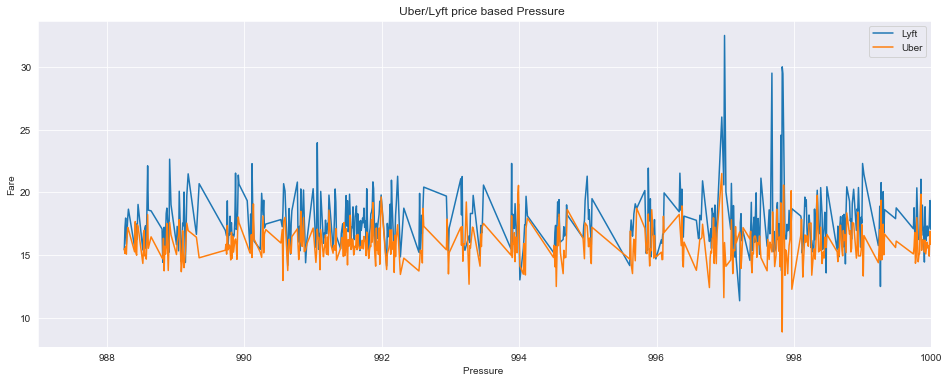

In [250]:
plt.figure(figsize = (16, 6))
for i in df['cab_type'].unique():
     plt.plot(df[df['cab_type']==i].groupby(by=['pressure'])['price'].mean(),label=i)
plt.xlabel('Pressure ')
plt.ylabel('Fare')
plt.legend()
plt.title('Uber/Lyft price based Pressure  ')
plt.xlim([987,1000])

### Correlation Check amongst columns  

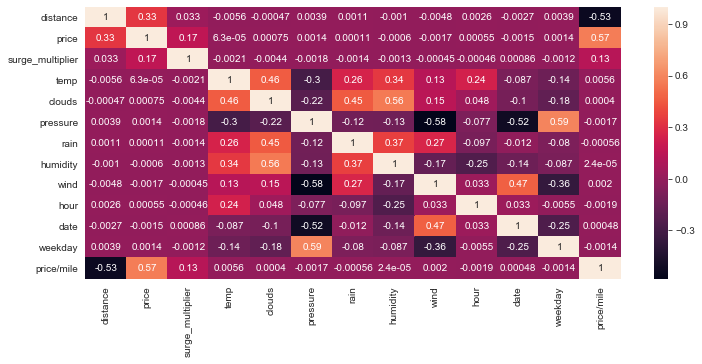

In [34]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(method='spearman'),annot=True)
plt.show()

In [14]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [17]:
#check correlation betwwen categorical and numerical 
num_cols = df.select_dtypes(include=[np.number])
cat_cols = df.select_dtypes(include=[np.object])

corr = []
for i in num_cols.columns:
    temp = []
    for j in cat_cols.columns:
        temp.append(correlation_ratio(df[j], df[i]))
    corr.append(temp)
    
df.reset_index(drop=['index'], inplace=True)
corr_cat_num = pd.DataFrame(corr, index = num_cols.columns, columns = cat_cols.columns)    

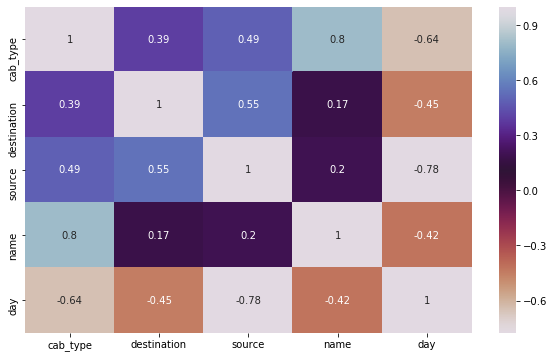

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_cat_num.corr(method='spearman'),cmap= 'twilight_r',annot=True)
plt.show()

Import Latitude/Longitude for distance prediction  

In [216]:
geolocator = Nominatim()
states = df['source'].unique()
d = dict(zip(states, pd.Series(states).apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))))
lat =pd.DataFrame(d, index=['lat','long']).T
Lat= lat.reset_index()
Lat['source']=Lat['index']
Lat.drop(columns=['index'],inplace=True)
Lat

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


,lat,long,source
0,42.350500,-71.102560,Boston University
1,50.821467,-1.451835,South Station
2,39.744650,-104.996402,Theatre District
3,42.339030,-71.087913,Northeastern University
4,42.358708,-71.067829,Beacon Hill
5,39.466236,-0.377377,North Station
6,42.363919,-71.063899,West End
7,42.365097,-71.054495,North End
8,41.639308,-93.696254,Haymarket Square
9,40.707612,-74.009378,Financial District


## Feature Engineering

There were many features in the dataset that seeemed redundant or unrelated to the prediction's goal. so i decided to delete some columns. 

Before exporting the data for modelling purposes, i did one-Hot encoding for selected categorical columns.   

In [257]:
#drop unecessary features 
df.drop(['surge_multiplier','product_id','datetime','date','weekday'],axis=1, inplace=True)


In [258]:
#Convert categorical data to numerical data
df= pd.get_dummies(data=df, columns=['source','name','day'],drop_first=True)
df['cab_type']=df.cab_type.map({'Uber':0, 'Lyft':1})

In [ ]:
data_clean.to_csv('data_clean.csv')